<a href="https://colab.research.google.com/github/sandhyaparna/Data-Science/blob/master/Deep%20Learning/Images/Implementing_LR_range_test_Learning_rate_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for beginners

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/beginner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Build a neural network that classifies images.
2. Train this neural network.
3. And, finally, evaluate the accuracy of the model.

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

In [ ]:
import tensorflow as tf

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [ ]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [ ]:
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(x_train, y_train, start_lr=1e-5, end_lr=1, batch_size=512, epochs=5)

Epoch 1/5
118/118 [==============================] - 1s 11ms/step - loss: 0.0605 - accuracy: 0.9817
Epoch 2/5
118/118 [==============================] - 1s 9ms/step - loss: 0.0557 - accuracy: 0.9830
Epoch 3/5
118/118 [==============================] - 1s 7ms/step - loss: 0.0513 - accuracy: 0.9842
Epoch 4/5
118/118 [==============================] - 1s 7ms/step - loss: 0.1306 - accuracy: 0.9608


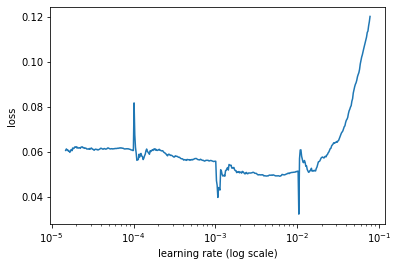

In [ ]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

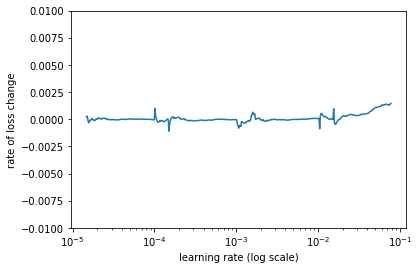

In [ ]:
# Plot rate of change of the loss
# Ignore 20 batches in the beginning and 5 in the end
# Smooth the curve using simple moving average of 20 batches
# Limit the range for y axis to (-0.02, 0.01)
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

For each example the model returns a vector of "[logits](https://developers.google.com/machine-learning/glossary#logits)" or "[log-odds](https://developers.google.com/machine-learning/glossary#log-odds)" scores, one for each class.

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.14067957,  0.05065668,  0.70477337, -0.01232545,  0.15227976,
        -0.1808649 , -0.6233727 , -0.2591579 ,  0.24132408,  0.48434493]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [ ]:
tf.nn.softmax(predictions).numpy()

array([[0.07802289, 0.09447528, 0.18171783, 0.08870855, 0.10458096,
        0.07494967, 0.04814942, 0.06930547, 0.11432049, 0.1457695 ]],
      dtype=float32)

Note: It is possible to bake this `tf.nn.softmax` in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to
provide an exact and numerically stable loss calculation for all models when using a softmax output. 

The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class:
It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [ ]:
loss_fn(y_train[:1], predictions).numpy()

2.5909386

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [ ]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3030 - accuracy: 0.9123
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1451 - accuracy: 0.9574
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1080 - accuracy: 0.9673
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0897 - accuracy: 0.9722
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0766 - accuracy: 0.9763


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0700 - accuracy: 0.9781


[0.0700211152434349, 0.9781000018119812]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[3.04377835e-07, 2.54188204e-09, 2.47226035e-05, 3.11462441e-03,
        4.44908971e-10, 1.29766093e-07, 8.96151371e-13, 9.96842861e-01,
        4.59115796e-07, 1.69061732e-05],
       [1.08277955e-08, 5.71746386e-06, 9.99907494e-01, 1.67789549e-05,
        1.57107996e-13, 6.59124053e-05, 1.12526106e-06, 3.99786839e-13,
        3.00717352e-06, 5.11569248e-13],
       [6.16338866e-07, 9.97986078e-01, 2.85780174e-04, 3.13013334e-05,
        5.90716736e-05, 4.87184252e-06, 1.39391941e-05, 1.20597612e-03,
        4.11329587e-04, 1.07319227e-06],
       [9.99705613e-01, 3.07341641e-09, 1.37079160e-05, 2.16809937e-07,
        1.91580716e-06, 1.30518913e-06, 1.01174344e-04, 1.48589766e-04,
        4.29782233e-07, 2.70057080e-05],
       [8.97403254e-07, 5.15086918e-10, 5.16940781e-06, 6.98826028e-08,
        9.98245716e-01, 1.13836666e-06, 4.78813899e-06, 1.40978605e-04,
        1.80152620e-06, 1.59929111e-03]], dtype=float32)>